# use opencv to infer

In [ ]:
!pip install opencv-python==4.4.0.40 imutils -i https://opentuna.cn/pypi/web/simple

In [21]:
import time
import cv2 as cv
import matplotlib.pyplot as plt

def yolo_infer(weight,names,cfg,pic):
    #TODO: define endpoint output
    model = cv.dnn.readNet(weight,cfg)
    model.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
    model.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA_FP16)
    net = cv.dnn_DetectionModel(model)
    
#     net = cv.dnn_DetectionModel(cfg,weight)
    net.setInputSize(608, 608)
    net.setInputScale(1.0 / 255)
    net.setInputSwapRB(True)
    frame = cv.imread(pic)
    with open(names, 'rt') as f:
        names = f.read().rstrip('\n').split('\n')

    start = time.time()
    classes, confidences, boxes = net.detect(frame, confThreshold=0.1, nmsThreshold=0.4)
    end = time.time()
    print("detect time:", end-start)
    for classId, confidence, box in zip(classes.flatten(), confidences.flatten(), boxes):
        label = '%.2f' % confidence
        label = '%s: %s' % (names[classId], label)
        labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        left, top, width, height = box
        top = max(top, labelSize[1])
        cv.rectangle(frame, box, color=(0, 255, 0), thickness=3)
        cv.rectangle(frame, (left, top - labelSize[1]), (left + labelSize[0], top + baseLine), (255, 255, 255), cv.FILLED)
        cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    plt.imshow(frame)
    plt.show

    cv.imwrite('./res.jpg', frame)
    print ("<<<<done")
    return classes,confidences,boxes

detect time: 1.2137031555175781
<<<<done
yolo_infer time: 1.3111162185668945
Done inference! 
CPU times: user 7.87 s, sys: 232 ms, total: 8.1 s
Wall time: 1.31 s


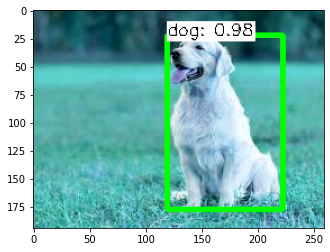

In [23]:
%%time
import time

weight = './pretrained_model/yolov4.weights'
names = './pretrained_model/coco.names'
cfg = './pretrained_model/yolov4.cfg'
download_file_name='./dog.jpg'

start = time.time()
classes, confidences, boxes = yolo_infer(weight,names,cfg, download_file_name)
end = time.time()
print("yolo_infer time:", end-start)
#print("image_path:{},label:{}".format(download_file_name, label))
print ("Done inference! ")
inference_result = {
    'classes':classes,
    'confidences':confidences,
    'boxes':boxes
}


# infer on a mp4 file

In [24]:
import cv2 as cv
import matplotlib.pyplot as plt
import time
import imutils

def yolo_infer(weight,cfg,frame):
    net = cv.dnn_DetectionModel(cfg,weight)
    net.setInputSize(608, 608)
    net.setInputScale(1.0 / 255)
    net.setInputSwapRB(True)
    #frame = cv.imread(pic)

    classes, confidences, boxes = net.detect(frame, confThreshold=0.1, nmsThreshold=0.4)
    print ("<<<<done")
    return classes,confidences,boxes


def detect_objects(weight,names,cfg,video):

    # get video frames and pass to YOLO for output

    cap = cv.VideoCapture(video)
    writer = None
    # try to determine the total number of frames in the video file
    try:
        prop = cv.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
            else cv.CAP_PROP_FRAME_COUNT
        total = int(cap.get(prop))
        print("[INFO] {} total frames in video".format(total))
    # an error occurred while trying to determine the total
    # number of frames in the video file
    except:
        print("[INFO] could not determine # of frames in video")
        print("[INFO] no approx. completion time can be provided")
        total = -1
        
    i=0
    # initialize video stream, pointer to output video file and grabbing frame dimension
        
    while(cap.isOpened()):
        stime= time.time()
        ret, frame = cap.read()
        classes, confidences, boxes = yolo_infer(weight,cfg,frame)
        end = time.time()

        i = i+1
        print (i)

        if ret:
            for classId, confidence, box in zip(classes.flatten(), confidences.flatten(), boxes):
                label = '%.2f' % confidence
                label = '%s: %s' % (names[classId], label)
                labelSize, baseLine = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                left, top, width, height = box
                top = max(top, labelSize[1])
                cv.rectangle(frame, box, color=(0, 255, 0), thickness=3)
                cv.rectangle(frame, (left, top - labelSize[1]), (left + labelSize[0], top + baseLine), (255, 255, 255), cv.FILLED)
                cv.putText(frame, label, (left, top), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

            if writer is None:
                # Initialize the video writer
                fourcc = cv.VideoWriter_fourcc(*"MP4V")
                writer = cv.VideoWriter('./res.mp4', fourcc, 30,
                                        (frame.shape[1], frame.shape[0]), True)
                # some information on processing single frame
                if total > 0:
                    elap = (end - stime)
                    print("[INFO] single frame took {:.4f} seconds".format(elap))
                    print("[INFO] estimated total time to finish: {:.4f}".format(
                        elap * total))


            writer.write(frame)

            print('FPS {:1f}'.format(1/(time.time() -stime)))
            if cv.waitKey(1)  & 0xFF == ord('q'):
                break
            if i>30:
                break
        else:
            break

    print ("<<<<clean up")
    writer.release()
    cap.release()


In [7]:
weight = './pretrained_model/yolov4.weights'
names = './pretrained_model/coco.names'
cfg = './pretrained_model/yolov4.cfg'
video='car_chase_01.mp4'
detect_objects(weight,names,cfg,video)

[INFO] 350 total frames in video
<<<<done
1
[INFO] single frame took 1.7519 seconds
[INFO] estimated total time to finish: 613.1564
FPS 0.567765
<<<<done
2
FPS 0.593175
<<<<done
3
FPS 0.646279
<<<<done
4
FPS 0.653681
<<<<done
5
FPS 0.644788
<<<<done
6
FPS 0.654020
<<<<done
7
FPS 0.656935
<<<<done
8
FPS 0.645874
<<<<done
9
FPS 0.653382
<<<<done
10
FPS 0.651257
<<<<done
11
FPS 0.655147
<<<<done
12
FPS 0.649887
<<<<done
13
FPS 0.657694
<<<<done
14
FPS 0.653892
<<<<done
15
FPS 0.656140
<<<<done
16
FPS 0.648517
<<<<done
17
FPS 0.646443
<<<<done
18
FPS 0.655901
<<<<done
19
FPS 0.655931
<<<<done
20
FPS 0.653686
<<<<done
21
FPS 0.657166
<<<<done
22
FPS 0.655676
<<<<done
23
FPS 0.654170
<<<<done
24
FPS 0.657621
<<<<done
25
FPS 0.658674
<<<<done
26
FPS 0.657537
<<<<done
27
FPS 0.657954
<<<<done
28
FPS 0.652414
<<<<done
29
FPS 0.656973
<<<<done
30
FPS 0.654793
<<<<done
31
FPS 0.653737
<<<<clean up


# test local host

In [1]:
!curl http://localhost:8080/ping 

{'status': 'Healthy'}


In [30]:
%%time
import requests
import json

url='http://localhost:8080/invocations'

# bucket = 'spot-bot-asset'
bucket = 'spot-bot-exampledata-cn-northwest-1-343958593302'
image_uri = 'end/dog.jpg'
test_data = {
    'bucket' : bucket,
    'image_uri' : image_uri,
    'content_type': "application/json",
}
payload = json.dumps(test_data)


r = requests.post(url,data=payload)

#show result
print (r.text)

{"classes": [[16]], "confidences": [[0.9775161147117615]], "boxes": [[119, 22, 104, 156]]}
CPU times: user 6.22 ms, sys: 89 µs, total: 6.31 ms
Wall time: 1.6 s


In [14]:
%%time
import requests
import json

url='http://localhost:8080/invocations'

# bucket = 'spot-bot-asset'
bucket = 'spot-bot-exampledata-cn-northwest-1-343958593302'
# image_uri = 'car_chase_01.mp4'
image_uri = '0112.mp4'
test_data = {
    'bucket' : bucket,
    's3_url' : image_uri,
    'type': "video",
    'output_s3_prefix': "output"
}
payload = json.dumps(test_data)


r = requests.post(url,data=payload)

#show result
print (r.text)

{"vidoe": "infer start!——>please go to cloudformation to see the process is done or not!!"}
CPU times: user 4.52 ms, sys: 0 ns, total: 4.52 ms
Wall time: 6.63 ms


# test endpoint

In [1]:
%%time 

def infer(input_image):
    from boto3.session import Session
    import json

#     bucket = 'predictive-solution'
    bucket = 'spot-bot-exampledata-cn-northwest-1-343958593302'
    image_uri = input_image
    test_data = {
        'bucket' : bucket,
        'image_uri' : image_uri,
        'content_type': "application/json",
    }
    payload = json.dumps(test_data)


    session = Session()

    runtime = session.client("runtime.sagemaker")
    response = runtime.invoke_endpoint(
        EndpointName='yolov4',
        ContentType="application/json",
        Body=payload)

    result = json.loads(response["Body"].read())
    print (result)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [2]:
# !aws s3 ls s3://predictive-solution/yolotest/dog.jpg
!aws s3 ls s3://spot-bot-exampledata-cn-northwest-1-343958593302/end/dog.jpg

2020-11-24 12:13:16       7644 dog.jpg


In [6]:
%%time
# infer('yolotest/dog.jpg')
infer('end/dog.jpg')

{'classes': [[16]], 'confidences': [[0.9775161147117615]], 'boxes': [[119, 22, 104, 156]]}
CPU times: user 64.3 ms, sys: 3.82 ms, total: 68.1 ms
Wall time: 3.85 s


In [17]:
%%time 

def infer_video(input_image):
    from boto3.session import Session
    import json

#     bucket = 'predictive-solution'
    bucket = 'spot-bot-exampledata-cn-northwest-1-343958593302'
    image_uri = input_image
    test_data = {
        'bucket' : bucket,
        's3_url' : image_uri,
        'type': "video",
        'output_s3_prefix': "output"
    }
    payload = json.dumps(test_data)


    session = Session()

    runtime = session.client("runtime.sagemaker")
    response = runtime.invoke_endpoint(
        EndpointName='yolov4',
        ContentType="application/json",
        Body=payload)

    result = json.loads(response["Body"].read())
    print (result)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [41]:
%%time
infer_video('end/car_chase_01.mp4')

{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
CPU times: user 35.6 ms, sys: 4.03 ms, total: 39.6 ms
Wall time: 32.5 s


In [51]:
%%time
infer_video('end/0112.mp4')

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from model with message "Your invocation timed out while waiting for a response from container model. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://cn-northwest-1.console.aws.amazon.com/cloudwatch/home?region=cn-northwest-1#logEventViewer:group=/aws/sagemaker/Endpoints/yolov4 in account 343958593302 for more information.

In [42]:
%%time
for _ in range(100):
    infer_video('end/car_chase_01.mp4')

{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done

In [52]:
%%time
for _ in range(8):
    infer_video('end/0112.mp4')

{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
{'vidoe': 'infer start!——>please go to cloudformation to see the process is done or not!!'}
CPU times: user 333 ms, sys: 15.9 ms, total: 349 ms
Wall time: 46.7 s


### speed up

In [51]:
%%time 
import multiprocessing as mul

pool = mul.Pool(5)
rel = pool.map(infer, ['end/test2.jpg','end/test.jpg','end/test2.jpg','end/test2.jpg','end/test2.jpg','end/test2.jpg'])
print(rel)

{'result': 'Hﺋ\ue82cﺥ'}
{'result': '粜秽ｌ分行名耨'}
{'result': '粜秽ｌ分行名耨'}
{'result': '粜秽ｌ分行名耨'}
{'result': '粜秽ｌ分行名耨'}
{'result': '粜秽ｌ分行名耨'}
[None, None, None, None, None, None]
CPU times: user 24.6 ms, sys: 17.9 ms, total: 42.5 ms
Wall time: 3.91 s


In [50]:
%%time 
import multiprocessing as mul

pool = mul.Pool(5)
rel = pool.map(infer, ['end/test2.jpg'])
print(rel)

{'result': '粜秽ｌ分行名耨'}
[None]
CPU times: user 7.21 ms, sys: 23.6 ms, total: 30.8 ms
Wall time: 1.74 s
